<a href="https://colab.research.google.com/github/rdemarqui/traffic_prediction_and_congestion/blob/main/LTE_Cell_Traffic_Grow_and_Congestion_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTE Cell Traffic Grow and Congestion Forecasting

## I. Introduction

This code was writen based on paper:
* D. Chmieliauskas and D. Guršnys, "LTE Cell Traffic Grow and Congestion Forecasting," 2019 Open Conference of Electrical, Electronic and Information Sciences (eStream), 2019, pp. 1-5, doi: 10.1109/eStream.2019.8732145. PDF found on: https://www.researchgate.net/publication/345446849_LTE_Cell_Traffic_Grow_and_Congestion_Forecasting

The purpose of this work was to provide a replicable code for the [paperswithcode.com](https://paperswithcode.com/). For more details, go to: https://paperswithcode.com/paper/lte-cell-traffic-grow-and-congestion.

**Notes:**
1. The study of data distribution and the data cleaning steps were conducted beforehand and are outside the scope of this work, so they have been omitted from the code.
2. The results presented in this work were generated using real data from a cellular network. However, due to compliance reasons, the original data cannot be shared. Instead, a noised sample of the data is available for full code execution.
3. Some differences exist between the method proposed by the paper's authors and the approach taken in this work. These arose either due to insufficient details in the paper or our belief that the modifications would improve accuracy. In any case, these differences are noted throughout the code.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn import metrics
from datetime import datetime, timedelta
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)

from prophet import Prophet

In [ ]:
# Disable cmdstanpy warning
import logging, warnings, os
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Transform

The paper does not mention any data normalization techniques, but in our studies, we found that Prophet achieves better accuracy when applying the Box-Cox transformation. However, be aware that if your data contains negative or zero values, this transformation will cause an error.

In [ ]:
from scipy.special import inv_boxcox

### Evaluation Metrics

The authors used the following evaluation metrics:
* Explained Variance Score
* R² Score
* Mean Absolute Percentage Error (MAPE)

While MAPE is widely used, it has several drawbacks, including its high sensitivity to outliers, which are common in this type of data. Therefore, we will use SMAPE instead, as it is a slightly more robust metric. For further details, refer to Chris Tofallis' study titled "*A Better Measure of Relative Prediction Accuracy for Model Selection and Model Estimation*".

In [ ]:
def smape_metric(y_true, y_pred):
  smape = 1/len(y_true) * np.sum(2 * np.abs(y_true-y_pred) / (np.abs(y_true) + np.abs(y_pred)))
  return smape

metric_cols = ['sMAPE', 'EVS', 'R2']

def timeseries_evaluation_metrics_func(y_true, y_pred):
  sMAPE = smape_metric(y_true, y_pred)
  EVS = metrics.explained_variance_score(y_true, y_pred)
  R2 = metrics.r2_score(y_true, y_pred)

  return [sMAPE, EVS, R2]

## II. Total Daily Traffic Forecasting

### Getting Data

**Note:** In the original paper, the authors used 180 days, allocating 5 months for training and 1 month for forecast testing. In this work, we extended the training period to 1.5 years while maintaining 28 days for forecast testing. This approach allows us to leverage the annual seasonality that was not originally utilized by the authors.

In [ ]:
# Download data
current_dir = os.getcwd()
!wget -q https://github.com/rdemarqui/traffic_prediction_and_congestion/raw/main/datasets/df_daily_sample.csv
!wget -q https://github.com/rdemarqui/traffic_prediction_and_congestion/raw/main/datasets/df_hourly_sample.csv

In [ ]:
# Opening daily cell data
daily_traffic = pd.read_csv(os.path.join(current_dir, 'df_daily_sample.csv'), sep=';')
daily_traffic.head(10)

,Cell,Band(MHz),Date,Data_Volume
0,cell0001,1800,2019-01-01,9.402865e+06
1,cell0001,1800,2019-01-02,3.226008e+06
2,cell0001,1800,2019-01-03,5.870039e+06
3,cell0001,1800,2019-01-04,6.510932e+06
4,cell0001,1800,2019-01-05,7.400789e+06
5,cell0001,1800,2019-01-06,1.245551e+07
6,cell0001,1800,2019-01-07,1.198230e+07
7,cell0001,1800,2019-01-08,1.409375e+07
8,cell0001,1800,2019-01-09,1.783221e+07
9,cell0001,1800,2019-01-10,1.162847e+07


In [ ]:
# Renaming columns for Prophet standard, where ds its the date
# and y it's a target variable Data_Volume
daily_traffic.columns = ['Cell', 'Band(MHz)', 'ds', 'y']
daily_traffic['ds'] = pd.to_datetime(daily_traffic['ds'])

In [ ]:
# Checking cell quantity and data range
list_cells = daily_traffic.Cell.unique()
print(f'Dataset have {len(list_cells)} unique cells',
      f'with date between {min(daily_traffic.ds)} and {max(daily_traffic.ds)}.')

Dataset have 163 unique cells with date between 2019-01-01 00:00:00 and 2021-01-28 00:00:00.


In [ ]:
# Splitting dataset
n_days_forecast = 28
train_ini, train_end = '2019-01-01', '2020-07-01'
val_ini, val_end = train_end, datetime.strptime(train_end, "%Y-%m-%d") + timedelta(days=n_days_forecast)

df_daily_train = daily_traffic[(daily_traffic['ds'] >= train_ini) & (daily_traffic['ds'] < train_end)].copy()
df_daily_val = daily_traffic[(daily_traffic['ds'] >= val_ini) & (daily_traffic['ds'] < val_end)].copy()

### Forecasting

**Note:** The authors do not specify whether they used standard hyperparameters, or if they tuned. In this work, we customized all the seasonal parameters to enhance performance. This approach allows us to test various configurations and determine which one yields the best results.

In [ ]:
# Parameters
daily_params = [# Config01
                [{'changepoint_prior_scale': 1},                                        # Trend sensibility
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 0.5},   # Weekly Hyperparameters
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 0.01}],       # Yearly Hyperparameters

                # Config02
                [{'changepoint_prior_scale': 1},
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 1},
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 0.5}],

                # Config03
                [{'changepoint_prior_scale': 1},
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 1.5},
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 1}]
]

In [ ]:
final_result_daily = pd.DataFrame()

for cell in list_cells[:]:
  n_config = 1
  # Filtering cell
  df_train_temp = df_daily_train[df_daily_train['Cell']==cell].copy()
  df_val_temp = df_daily_val[df_daily_val['Cell']==cell].copy()

  # Applying Box-Cox
  #df_train_temp['y'], lambda_prophet = stats.boxcox(df_train_temp['y'])

  # Executing all configurations
  for params in daily_params:
    config = 'conf_' + str(n_config).zfill(len(str(len(daily_params))))

    # Instantiating the model
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                uncertainty_samples=0,      # Zeroed to speed up forecast
                **params[0])

    # Weekly seasonality
    m.add_seasonality(name='weekly', period=7, **params[1])

    # Yearly seasonality
    m.add_seasonality(name='yearly', period=365.25, **params[2])

    # Fit
    m.fit(df_train_temp)

    # Create future dataset
    future = m.make_future_dataframe(n_days_forecast, freq='d')

    # Forecast
    forecast = m.predict(future)

    # Applying inverse Box-Cox in forecast data
    #forecast['yhat'] = inv_boxcox(forecast['yhat'], lambda_prophet)

    # Insert config number
    forecast['configuration'] = config

    # Mergin forecasted and actual data
    temp_result_daily = pd.merge(df_val_temp,
                                 forecast[['ds', 'yhat', 'configuration']],
                                 left_on='ds',
                                 right_on='ds',
                                 how='inner')

    final_result_daily = pd.concat([final_result_daily, temp_result_daily])

    n_config += 1

### Evaluating

#### LTE Traffic Forecasting Accuracy Overall Result

In [ ]:
# Eveluating overall results for each configuration
evaluating_cols = metric_cols + ['Configuration']
overall_result_daily = pd.DataFrame(columns= evaluating_cols)
full_eval = []
daily_configurations = final_result_daily.configuration.unique()

for configuration in daily_configurations:
  temp_df = final_result_daily[final_result_daily['configuration']==configuration]
  temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
  temp_eval.append(configuration)
  full_eval.append(temp_eval)

overall_result_daily = pd.concat([overall_result_daily,
                                  pd.DataFrame(full_eval, columns= evaluating_cols)])
overall_result_daily.round(5)

,sMAPE,EVS,R2,Configuration
0,0.38675,0.92169,0.91266,conf_1
1,0.34949,0.92694,0.91700,conf_2
2,0.34744,0.92793,0.91791,conf_3


In [ ]:
# Eveluating individual results for each configuration
evaluating_cols_1 = metric_cols + ['Configuration', 'cell']
individual_result_daily = pd.DataFrame(columns=evaluating_cols_1)
ind_eval = []
daily_configurations = final_result_daily.configuration.unique()
cells_eval = final_result_daily['Cell'].unique()

for cell in cells_eval:
  temp_cell_df = final_result_daily[final_result_daily['Cell']==cell]

  for configuration in daily_configurations:
    temp_df = temp_cell_df[temp_cell_df['configuration']==configuration]
    temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
    temp_eval.append(configuration)
    temp_eval.append(cell)
    ind_eval.append(temp_eval)

individual_result_daily = pd.concat([individual_result_daily,
                                  pd.DataFrame(ind_eval, columns= evaluating_cols_1)])

**Note:** After run all desired configurations, pick one that best performed. This one will be used further, in the final solution.

In [ ]:
daily_prediction = final_result_daily[final_result_daily['configuration']=='conf_3'].copy().reset_index(drop=True)
daily_prediction.drop(['configuration'], axis=1, inplace=True)

#### Mean absolute percentage error vs forecast day
The chart shows the calculated forecast results for all LTE cells value for every forecast day from 1 to 28

In [ ]:
def daily_metrics(dataset, metric):
  daily_metric = []

  for day in dataset['ds'].unique():
    temp_d_forecast = dataset[dataset['ds']==day]
    performance = metric(temp_d_forecast.y, temp_d_forecast.yhat)
    daily_metric.append(performance)

  return daily_metric

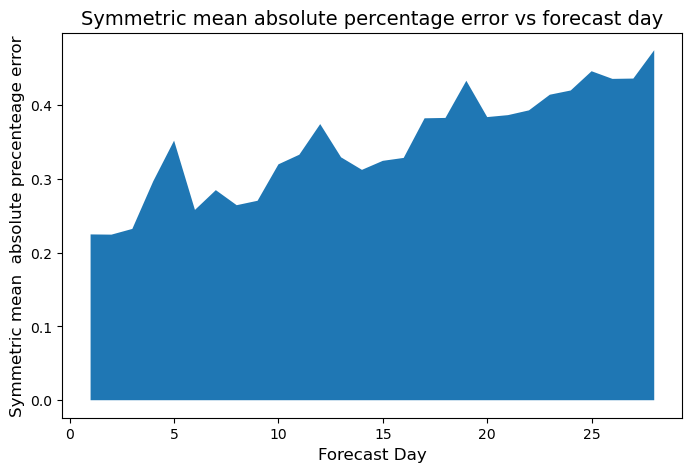

In [ ]:
daily_smape = daily_metrics(daily_prediction, smape_metric)

# Plotting
x = range(1, len(daily_smape)+1)
y = daily_smape
plt.fill_between( x, y)
plt.title('Symmetric mean absolute percentage error vs forecast day', fontsize=14)
plt.xlabel('Forecast Day', fontsize=12)
plt.ylabel('Symmetric mean  absolute precenteage error', fontsize=12);

#### R² score and explained variance score vs forecast day

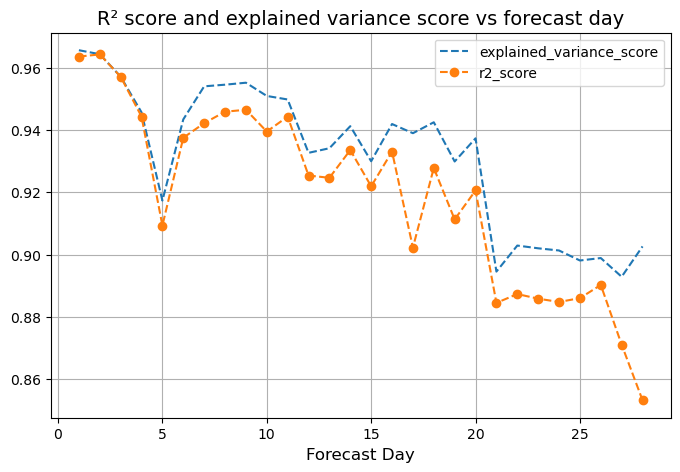

In [ ]:
daily_evs = daily_metrics(daily_prediction, metrics.explained_variance_score)
daily_r2 = daily_metrics(daily_prediction, metrics.r2_score)

# Plotting
x = range(1, len(daily_r2)+1)
plt.plot(x, daily_evs, '--')
plt.plot(x, daily_r2, '--o')
plt.title('R² score and explained variance score vs forecast day', fontsize=14)
plt.xlabel("Forecast Day", fontsize=12)
plt.legend(['explained_variance_score', 'r2_score'])
plt.grid();

#### Scatter of forecasting accuracy (sMAPE) vs traffic volume

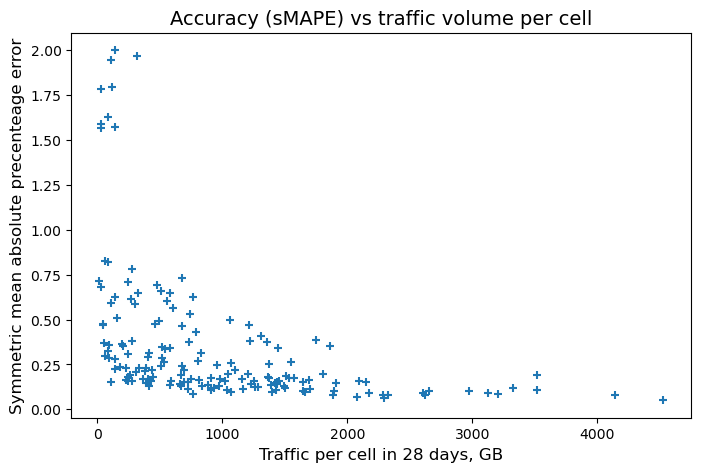

In [ ]:
cell_traffic = []
cell_smape = []

for cell in daily_prediction.Cell.unique():
  temp = daily_prediction[daily_prediction['Cell']==cell].copy()
  cell_traffic.append(temp.y.sum())
  cell_smape.append(smape_metric(temp.y, temp.yhat))

# Plotting
plt.scatter(np.array(cell_traffic)/1024/1024, cell_smape, marker='+')
plt.title('Accuracy (sMAPE) vs traffic volume per cell', fontsize=14)
plt.xlabel('Traffic per cell in 28 days, GB', fontsize=12)
plt.ylabel('Symmetric mean absolute precenteage error', fontsize=12);

## III. Hourly Traffic Trend

### Getting Data

Using the available 28 days of hourly data in the second step.

In [ ]:
# Opening daily cell data
hourly_traffic = pd.read_csv(os.path.join(current_dir, 'df_hourly_sample.csv'), sep=';')

In [ ]:
# Calculating PRB usage
hourly_traffic['PRB_Util_Qty_True'] = hourly_traffic['PRB_Utilization_Percent']*hourly_traffic['PRB_Available_DL']
hourly_traffic['Datetime'] = pd.to_datetime(hourly_traffic['Datetime'])

In [ ]:
# Renaming columns for Prophet standard, where 'ds' its the date
# and 'y' it's a target variable Data_Volume(GB)
hourly_traffic.columns = ['Cell', 'ds', 'y', 'PRB_Available_DL', 'PRB_Utilization_Percent', 'PRB_Util_Qty_True']

In [ ]:
# Checking cell quantity and data range
list_cells = hourly_traffic.Cell.unique()
print(f'Dataset have {len(list_cells)} unique cells',
      f'with date between {min(hourly_traffic.ds)} and {max(hourly_traffic.ds)}.')

Dataset have 163 unique cells with date between 2019-01-01 00:00:00 and 2021-01-28 23:00:00.


In [ ]:
# Splitting dataset
# We will use the same period from daily traffic, except train_ini witch we will use last 30 days
train_ini = datetime.strptime(train_end, "%Y-%m-%d") - timedelta(days=30)
n_hour_forecast = (val_end - datetime.strptime(val_ini, "%Y-%m-%d")).days * 7

df_hourly_train = hourly_traffic[(hourly_traffic['ds'] >= train_ini) & (hourly_traffic['ds'] < train_end)].copy()
df_hourly_val = hourly_traffic[(hourly_traffic['ds'] >= val_ini) & (hourly_traffic['ds'] < val_end)].copy()

df_hourly_train.head()

,Cell,ds,y,PRB_Available_DL,PRB_Utilization_Percent,PRB_Util_Qty_True
1760928,cell0001,2020-06-01 00:00:00,1.158804e+06,100.0,0.096667,9.666667
1760929,cell0001,2020-06-01 01:00:00,4.515076e+05,100.0,0.051667,5.166667
1760930,cell0001,2020-06-01 02:00:00,6.314205e+05,100.0,0.053333,5.333333
1760931,cell0001,2020-06-01 03:00:00,1.551132e+05,100.0,0.050000,5.000000
1760932,cell0001,2020-06-01 04:00:00,1.360913e+04,100.0,0.050000,5.000000


**Note:** As discussed in the section *B. LTE Network Level Throughput to Traffic Relation*, one factor influencing cell resource occupancy is the volume of traffic generated by users. Our studies have shown that this volume varies throughout the day, distinguishing between weekdays and weekends.

To better capture this difference, we added two conditional columns to the dataset—one indicating weekdays and the other indicating weekends. Additionally, we incorporated two custom conditional seasonalities into the algorithm to reflect these variations.

In [ ]:
# Weekend function
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

In [ ]:
# Creating weekend/weekday columns
df_hourly_train['weekend'] = df_hourly_train['ds'].apply(is_weekend)
df_hourly_train['weekday'] = ~df_hourly_train['ds'].apply(is_weekend)
df_hourly_val['weekend'] = df_hourly_val['ds'].apply(is_weekend)
df_hourly_val['weekday'] = ~df_hourly_val['ds'].apply(is_weekend)

### Forecasting

**Notes:**
1. As we're only interested in hourly traffic distribution between weekdays and weekends, we will use **growth as flat** and choose two days forecast, been one for weekday and one for weekend.
2. In this step we also add more than one configuration to check which one fits best in hourly distribution.

In [ ]:
# Parameters
hourly_params = [
                 # Config01
                 [{'growth': 'flat'},                                                     # Trend growth
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.1}],    # Daily Hyperparameters

                 # Config02
                 [{'growth': 'flat'},
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.05}],

                 # Config03
                 [{'growth': 'flat'},
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.01}]
]

In [ ]:
models_hourly = pd.DataFrame()

for cell in list_cells[:]:

  n_config = 1
  # Filtering cell
  df_train_temp = df_hourly_train[df_hourly_train['Cell']==cell].copy()
  df_val_temp = df_hourly_val[df_hourly_val['Cell']==cell].copy()

  # Applying Box-Cox
  df_train_temp['y'], lambda_prophet = stats.boxcox(df_train_temp['y'])

  # Executing all configurations
  for params in hourly_params:
    config = 'conf_' + str(n_config).zfill(len(str(len(hourly_params))))

    # Instantiating the model
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                uncertainty_samples=0,      # Zeroed to speed up forecast
                **params[0])

    # Daily seasonality
    m.add_seasonality(name='daily_weekend', period=1, condition_name='weekend', **params[1])
    m.add_seasonality(name='daily_weekday', period=1, condition_name='weekday', **params[1])

    # Fit
    m.fit(df_train_temp)

    # Create future dataset
    date_range = pd.date_range(start='2017-01-6', periods=48, freq='H')
    future = pd.DataFrame(date_range, columns=['ds'])

    # Creating conditional columns for future dataset
    future['weekend'] = future['ds'].apply(is_weekend)
    future['weekday'] = ~future['ds'].apply(is_weekend)

    # Forecast
    forecast = m.predict(future)

    # Applying inverse Box-Cox in forecast data
    forecast['yhat'] = inv_boxcox(forecast['yhat'], lambda_prophet)

    # Adding information columns
    forecast['Cell'] = cell
    forecast['weekday'] = ~forecast['ds'].apply(is_weekend)
    forecast['hour'] = forecast['ds'].dt.hour
    forecast['configuration'] = config

    models_hourly = pd.concat([models_hourly,
                               forecast[['Cell', 'weekday', 'hour', 'yhat', 'configuration']]])

    n_config += 1

As we can see below, there are differences in behavior between weekdays and weekend. We will use this in the traffic distribution.

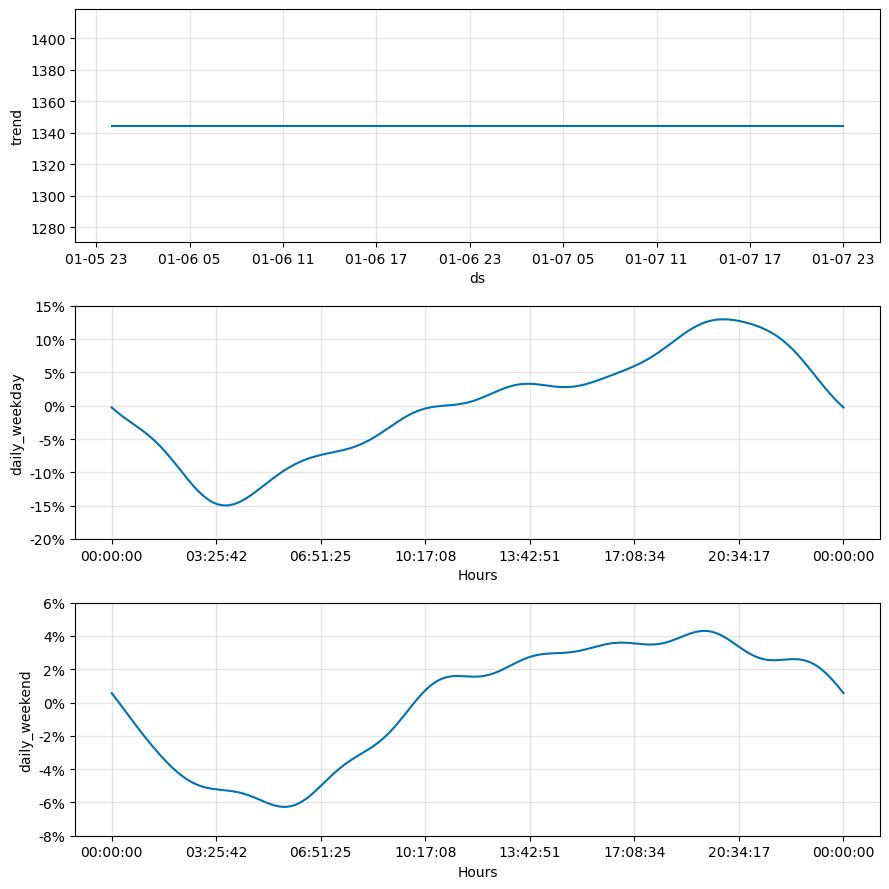

In [ ]:
m.plot_components(forecast);

In [ ]:
# Calculating cell proportional hourly traffic per day and configuration
models_hourly['yhat%'] = models_hourly['yhat'] / models_hourly.groupby(['Cell', 'weekday', 'configuration'])['yhat'].transform('sum')
models_hourly.drop(columns='yhat', inplace=True)

### Peak daily traffic

To obtain peak daily traffic, the authors recommend proportionally distributing the hourly prediction values across the predicted daily traffic for the next 30 days. They argue that this method accurately reflects real traffic patterns while eliminating random peaks or drops, enabling a more precise forecast of traffic volume for each hour.

In [ ]:
# Getting the quantity and configurations name
n_conf_hourly = len(models_hourly.configuration.unique())
config_name = models_hourly.configuration.unique()

# Creating hourly dataset
final_result_hourly = daily_prediction.drop('y', axis=1)

# Creating hourly column for each cell and configuration
hours_24 = cycle(list(range(0, 24)))
configs = cycle(np.repeat(config_name, 24))

final_result_hourly = pd.DataFrame(np.repeat(final_result_hourly.values, 24 * n_conf_hourly, axis=0),
                                   columns=final_result_hourly.columns)
final_result_hourly['hour'] = [next(hours_24) for hour in range(len(final_result_hourly))]
final_result_hourly['configuration'] = [next(configs) for config in range(len(final_result_hourly))]

# Adding weekday status
final_result_hourly['weekday'] = ~final_result_hourly['ds'].apply(is_weekend)
final_result_hourly.rename(columns={'yhat':'daily_data_volume'}, inplace=True)

We joined daily and hour dataframe considering cell, hour, configuration and weekend/weekday status.

In [ ]:
# Merging daily prediction with hourly prediction
final_result_hourly = final_result_hourly.merge(models_hourly,
                                                on=['Cell', 'weekday', 'hour', 'configuration'],
                                                how='left')

# Distributing the hourly prediction values within the predicted daily traffic
final_result_hourly['yhat'] = final_result_hourly['daily_data_volume'] * final_result_hourly['yhat%']

final_result_hourly.rename(columns={'ds':'day'}, inplace=True)

# Creating timestamp
final_result_hourly['ds'] = final_result_hourly['day'] + final_result_hourly.hour.astype('timedelta64[h]')

In [ ]:
final_result_hourly = pd.merge(final_result_hourly[['Cell', 'day', 'ds', 'yhat',
                                                    'configuration', 'daily_data_volume', 'yhat%']],
                               df_hourly_val.drop(['weekend', 'weekday'], axis=1),
                               left_on=['Cell', 'ds'],
                               right_on=['Cell', 'ds'],
                               how='inner')
final_result_hourly = final_result_hourly.sort_values(by = ['Cell', 'configuration', 'ds']).copy()

### Evaluating

**Note:** Although the authors did not conduct precision measurements in this phase of the study, I have included the measurements presented in the previous section. This allows for the selection of the model configuration that best fits the validation data.

#### LTE Traffic Forecasting Accuracy Overall Result

In [ ]:
# Eveluating results for each configuration
evaluating_cols = metric_cols + ['Configuration']
overall_result_hourly = pd.DataFrame(columns= evaluating_cols)
full_eval = []
hourly_configurations = final_result_hourly.configuration.unique()

for configuration in hourly_configurations:
  temp_df = final_result_hourly[final_result_hourly['configuration']==configuration].copy()

  temp_df.dropna(inplace=True)   # Delete this line

  temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
  temp_eval.append(configuration)
  full_eval.append(temp_eval)

overall_result_hourly = pd.concat([overall_result_hourly,
                                  pd.DataFrame(full_eval, columns= evaluating_cols)])
overall_result_hourly

,sMAPE,EVS,R2,Configuration
0,0.522538,0.853745,0.847062,conf_1
1,0.525614,0.852252,0.845569,conf_2
2,0.672868,0.670672,0.663994,conf_3


In [ ]:
# Eveluating results for each configuration
evaluating_cols_1 = metric_cols + ['Configuration', 'cell']
individual_result_hourly = pd.DataFrame(columns=evaluating_cols_1)
ind_eval = []
hourly_configurations = final_result_hourly.configuration.unique()
cells_eval = final_result_hourly['Cell'].unique()

for cell in cells_eval:
  temp_cell_df = final_result_hourly[final_result_hourly['Cell']==cell]

  for configuration in hourly_configurations:
    temp_df = temp_cell_df[temp_cell_df['configuration']==configuration]
    temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
    temp_eval.append(configuration)
    temp_eval.append(cell)
    ind_eval.append(temp_eval)

individual_result_hourly = pd.concat([individual_result_hourly,
                                  pd.DataFrame(ind_eval, columns= evaluating_cols_1)])

**Note:** After run all desired configurations, pick one that best performed. This one will be used further, in the final solution.

In [ ]:
hourly_prediction = final_result_hourly[final_result_hourly['configuration']=='conf_1'].copy().reset_index(drop=True)
hourly_prediction.drop(['configuration'], axis=1, inplace=True)

# Calculating daily traffic %
hourly_prediction['y%'] = hourly_prediction['y'] / hourly_prediction.groupby(['Cell', 'day'])['y'].transform('sum')

#### LTE cell traffic  compared to traffic trend modeled

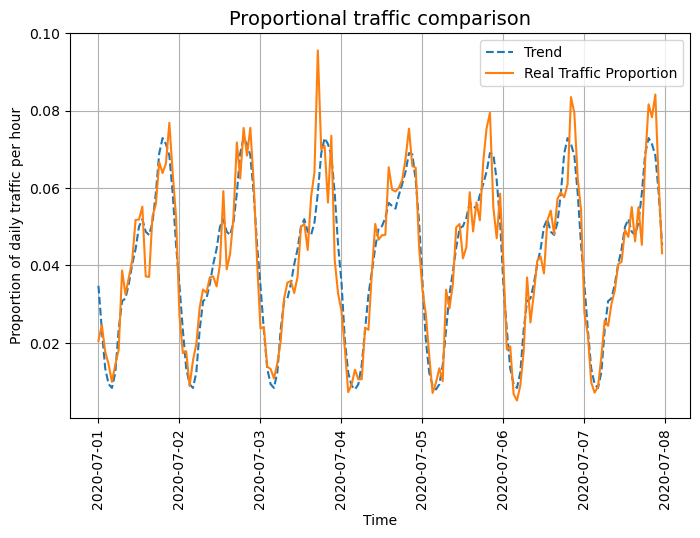

In [ ]:
example_cell = hourly_prediction[hourly_prediction['Cell']=='cell0012']
example_cell = example_cell.head(24*7)

plt.plot(example_cell.ds, example_cell['yhat%'], '--', label='Trend')
plt.plot(example_cell.ds, example_cell['y%'], label='Real Traffic Proportion')

plt.title('Proportional traffic comparison', fontsize=14)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Proportion of daily traffic per hour", fontsize=10)
plt.xticks(rotation=90)
plt.legend()
plt.grid();

## IV. LTE Cell Capacity Evaluation

### Espectral efficiency

Each cell has a unique behavior regard to reaching the threshold. This is defined by the spectral efficiency. The authors suggest to evaluate the cells individually and, through linear regression, verify the traffic demand that each cell supports before reaching the PRB utilization threshold.

#### Example of LTE cells with different spectral efficiency

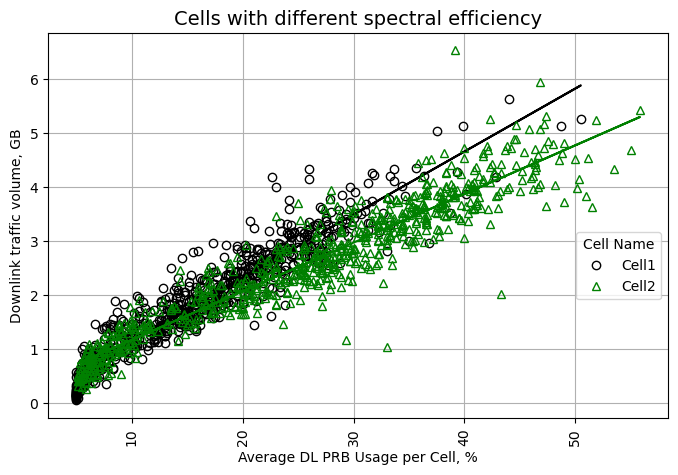

In [ ]:
cell_a, cell_b = 'cell0015', 'cell0020'

cell_a_x = df_hourly_train[df_hourly_train['Cell']==cell_a].PRB_Utilization_Percent*100
cell_a_y = (df_hourly_train[df_hourly_train['Cell']==cell_a].y)/1024/1024
cell_b_x = df_hourly_train[df_hourly_train['Cell']==cell_b].PRB_Utilization_Percent*100
cell_b_y = (df_hourly_train[df_hourly_train['Cell']==cell_b].y)/1024/1024

plt.plot(cell_a_x, cell_a_y, 'o', mfc='none', label='Cell1', c='k')
m, b = np.polyfit(cell_a_x, cell_a_y, 1)
plt.plot(cell_a_x, m*cell_a_x+b, c='k')

plt.plot(cell_b_x, cell_b_y, '^', mfc='none', label='Cell2', c='g')
m, b = np.polyfit(cell_b_x, cell_b_y, 1)
plt.plot(cell_b_x, m*cell_b_x+b, c='g')

plt.title('Cells with different spectral efficiency', fontsize=14)
plt.xlabel("Average DL PRB Usage per Cell, %", fontsize=10)
plt.ylabel("Downlink traffic volume, GB", fontsize=10)
plt.xticks(rotation=90)
plt.legend(title="Cell Name", bbox_to_anchor=(1, 0.5))
plt.grid();

### Calculation of spectral efficiency for each cell using regression

In [ ]:
prb_util_prediction = pd.DataFrame()
cell_coefficients = []

for cell in list_cells[:]:
  df_train_temp = df_hourly_train[df_hourly_train['Cell']==cell].copy()

  # Regression between Data Volume and PRB_Utilization_Qty on train dataset
  x = df_train_temp['y']
  y = df_train_temp['PRB_Util_Qty_True']
  var_lin = np.polyfit(x, y, 1) # Getting the coefficients
  cell_coefficients.append([cell, var_lin[0], var_lin[1]])

  # Calculating PRB usage
  df_test_temp = hourly_prediction[hourly_prediction['Cell']==cell].copy()
  df_test_temp['PRB_Util_Qty_Pred'] = np.array([var_lin[0]*val+var_lin[1] for val in df_test_temp.yhat])

  prb_util_prediction = pd.concat([prb_util_prediction, df_test_temp])

prb_util_prediction['PRB_Util_Perc_Pred'] = prb_util_prediction['PRB_Util_Qty_Pred']/prb_util_prediction['PRB_Available_DL']

### Congestion Threshold

The authors identified a strong correlation between the utilization of Physical Resource Blocks (PRBs) and average user throughput. They suggest that hourly samples with 20 or fewer unused PRBs should be classified as congested.

> *LTE 800MHz cell with 10MHz bandwidth can be considered as loaded if utilization is 60% or 20 PRB unused, and LTE 1800MHz with 20MHz bandwidth PRB utilization is above 80% (20 PRB left)* - Chmieliauskas & Guršnys, 2020

To simplify our calculations, we adopt as congested hourly samples over 70% PRB utilization, as shown below.

|Bandwidth (MHz)|PRB Available|Threshold (70% usage)|PRB unused|
|:---: |:---: |:---: |:---: |
|1,4|	6	|4	|2  |
|3	|15	|10	|5  |
|5	|25	|17	|8  |
|10	|50	|35	|15 |
|15	|75	|52	|23 |
|20	|100|70	|30 |

In [ ]:
# Calculating congestion samples
cong_threshold = 0.6

prb_util_prediction['Cong_True'] = prb_util_prediction.PRB_Utilization_Percent >= cong_threshold
prb_util_prediction['Cong_Pred'] = prb_util_prediction.PRB_Util_Qty_Pred / prb_util_prediction.PRB_Available_DL >= cong_threshold

In [ ]:
# Renaming and organizing columns
prb_util_prediction.rename(columns={'yhat':'daily_data_vol_pred',
                                    'yhat%': 'daily_data_vol_pred%',
                                    'y': 'daily_data_vol_true',
                                    'y%': 'daily_data_vol_true%',
                                    'PRB_Utilization_Percent': 'PRB_Util_%_True'}, inplace=True)

prb_util_prediction['weekend'] = prb_util_prediction['ds'].apply(is_weekend)

prb_util_prediction = prb_util_prediction[['Cell', 'day', 'ds', 'weekend', 'daily_data_vol_true',
                                           'daily_data_vol_true%', 'daily_data_vol_pred',
                                           'daily_data_vol_pred%', 'PRB_Available_DL',
                                           'PRB_Util_Qty_True', 'PRB_Util_%_True',
                                           'PRB_Util_Qty_Pred', 'PRB_Util_Perc_Pred',
                                           'Cong_True', 'Cong_Pred']]

### Evaluating

The primary goal of this study is to identify the cells that are likely to experience the highest levels of congestion. As previously mentioned, some cells exhibit greater usage during weekdays, such as those in the city center, while others, like those in residential neighborhoods, experience higher usage on weekends. To filter this data, we will classify cells as congested if they present an average of one or more daily congestion samples, as outlined below:

$
Congestioned \ cell =   
  \begin{cases}
    1  & \quad \text{for weekdays } n \text{ cong. samples} \geq n \text{ weekdays or}    \\
    & \quad \text{weekends } n \text{ cong. samples} \geq n \text{ weekends}    \\
    0  & \quad \text{otherwise}
  \end{cases}
$

In [ ]:
pred_congestion_eval = pd.pivot_table(prb_util_prediction, values=['Cong_Pred', 'Cong_True'],
                                      index='Cell', columns='weekend', aggfunc='sum')
pred_congestion_eval = pred_congestion_eval.droplevel(0, axis=1).reset_index()
pred_congestion_eval.columns = ['Cell', 'Cong_pred_weekday','Cong_pred_weekend','Cong_true_weekday','Cong_true_weekend']

pred_congestion_eval.head(15)

,Cell,Cong_pred_weekday,Cong_pred_weekend,Cong_true_weekday,Cong_true_weekend
0,cell0001,0,0,0,0
1,cell0002,0,0,0,1
2,cell0003,0,0,0,0
3,cell0004,0,0,0,0
4,cell0005,0,0,0,0
5,cell0006,0,0,1,0
6,cell0007,0,0,61,0
7,cell0008,0,0,6,0
8,cell0009,0,0,0,0
9,cell0010,0,0,0,0


## V. Conclusions

As stated at the beginning of this study, the objective is to replicate the work of D. Chmieliauskas and D. Guršnys in order to make the code available on paperswithcode.com. Throughout this work, several improvements were suggested, including data transformation using the Box-Cox method, utilizing a 1.5-year data history to capture annual seasonality, differentiating data between weekdays and weekends to better reflect the characteristics of individual cells, and adopting the sMAPE metric for its robustness against outliers. Although the results obtained in this study were not satisfactory, the absence of tuning offers the potential for further improvement.

---